In [35]:
import re
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from os import environ
from mpl_toolkits.basemap import Basemap

%matplotlib inline

import findspark
findspark.init()

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark import SparkContext
import string
import nltk
from nltk.corpus import stopwords 
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter
from geopy.geocoders import Nominatim
import spacy
import time

from spacy.lang.en import English

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
spacy.load('en')

# Dowloads the necessary toolkit modules
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw')

DATA_DIR = 'data/'

  Using cached https://files.pythonhosted.org/packages/19/c6/39b29bc6c6c94298e81624746cc69184c9cf064de24d8c40aa68f9eb8779/spacy-2.0.18-cp36-cp36m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/27/00/b2abd484bc4ef86e5c308acc6610e8f2c00c89b94701f42b9cc522ca70a4/thinc-6.12.1-cp36-cp36m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/db/6e/c6d1650f09b8b2910f149ec7c51fd2298e0e93a657f4496d4636c0a43675/cymem-2.0.2-cp36-cp36m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/cb/5a/4b6f2035443e463a326e3a81863f2b4850be76b4538fd4931b1aa63f79b6/preshed-2.0.1-cp36-cp36m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl
  Using cached https://f

Command "/Users/vincent/anaconda3/bin/python -u -c "import setuptools, tokenize;__file__='/private/var/folders/bj/mfjd88vn2lx97lhhng98hs1m0000gn/T/pip-install-0gfzd0ve/regex/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" install --record /private/var/folders/bj/mfjd88vn2lx97lhhng98hs1m0000gn/T/pip-record-pzrls5ao/install-record.txt --single-version-externally-managed --compile" failed with error code 1 in /private/var/folders/bj/mfjd88vn2lx97lhhng98hs1m0000gn/T/pip-install-0gfzd0ve/regex/
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vincent/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/vincent/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/vincent/nltk_data...
[nltk_data]   Package averaged_perceptro

# IMDb

We'll be using four of the IMDB datasets: 
1. basics - for various metadata about the movie/tv series
* principals - principals - for the character name info
* episode - to match the subtitles tv series episodes with the overall series in the database
* ratings - for the ratings and views info

All of them are available for dowload and described here: [IMDb](https://www.imdb.com/interfaces/).

In [2]:
# Loads the IMDb datasets
basics = spark.read.csv(DATA_DIR + 'title.basics.tsv.gz', sep='\t', header=True, nullValue="\\N")
principals = spark.read.csv(DATA_DIR + 'title.principals.tsv.gz', sep='\t', header=True, nullValue='\\N')
episode = spark.read.csv(DATA_DIR + 'title.episode.tsv.gz', sep='\t', header=True,  nullValue="\\N")
ratings = spark.read.csv(DATA_DIR + 'title.ratings.tsv.gz', sep='\t', header=True,  nullValue="\\N")

In [3]:
basics.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: string (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: string (nullable = true)
 |-- genres: string (nullable = true)



In [4]:
principals.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- ordering: string (nullable = true)
 |-- nconst: string (nullable = true)
 |-- category: string (nullable = true)
 |-- job: string (nullable = true)
 |-- characters: string (nullable = true)



In [5]:
episode.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- parentTconst: string (nullable = true)
 |-- seasonNumber: string (nullable = true)
 |-- episodeNumber: string (nullable = true)



In [6]:
ratings.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- averageRating: string (nullable = true)
 |-- numVotes: string (nullable = true)



We only need the following fields from every table:
* basics:
    * tconst, startYear, endYear (for TV series), genres
* episode:
    * all fields
* ratings:
    * all fields

In [7]:
basics.select('titleType').distinct().show()

+------------+
|   titleType|
+------------+
|    tvSeries|
|tvMiniSeries|
|     tvMovie|
|   tvEpisode|
|       movie|
|   tvSpecial|
|       video|
|   videoGame|
|     tvShort|
|       short|
+------------+



We're not interested in the `videoGame`, `video`, `tvShort` or `short` types, thus we filter them out.

In [8]:
# Removes the originalTitle and isAdult columns
basics = basics.filter(col('titleType') != 'short').filter(
    col('titleType') != 'videoGame').filter(col('titleType') != 'tvShort').filter(col('titleType') != 'videos')

# Removes episodes with empty series or episode numbers
episode = episode.filter(episode.seasonNumber.isNotNull()).filter(episode.episodeNumber.isNotNull()).withColumnRenamed(
    "tconst", "episodeTconst")

In [9]:
# Note that we leave the endYear column because it is valid for the TV Series, e.x.
basics.filter(col('primaryTitle') == 'Twin Peaks').show(5)

+---------+---------+------------+-------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|primaryTitle|originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+------------+-------------+-------+---------+-------+--------------+--------------------+
|tt0098936| tvSeries|  Twin Peaks|   Twin Peaks|      0|     1990|   1991|            47| Crime,Drama,Mystery|
|tt0186641|    video|  Twin Peaks|   Twin Peaks|      1|     1993|   null|          null|               Adult|
|tt2395641|tvEpisode|  Twin Peaks|   Twin Peaks|      0|     2006|   null|          null|         Documentary|
|tt2650780|tvEpisode|  Twin Peaks|   Twin Peaks|      0|     2013|   null|            44|Adventure,Reality-TV|
|tt3225942|tvEpisode|  Twin Peaks|   Twin Peaks|      0|     2013|   null|            43|          Reality-TV|
+---------+---------+------------+-------------+-------+---------+-------+--------------+--------------------+
o

In [10]:
basics.show(5)

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000009|    movie|          Miss Jerry|          Miss Jerry|      0|     1894|   null|            45|             Romance|
|tt0000147|    movie|The Corbett-Fitzs...|The Corbett-Fitzs...|      0|     1897|   null|            20|Documentary,News,...|
|tt0000335|    movie|Soldiers of the C...|Soldiers of the C...|      0|     1900|   null|          null|     Biography,Drama|
|tt0000502|    movie|            Bohemios|            Bohemios|      0|     1905|   null|           100|                null|
|tt0000574|    movie|The Story of the ...|The Story of the ...|      0|     1906|   null|            70|Biography,Crim

In [11]:
episode.show(5)

+-------------+------------+------------+-------------+
|episodeTconst|parentTconst|seasonNumber|episodeNumber|
+-------------+------------+------------+-------------+
|    tt0041951|   tt0041038|           1|            9|
|    tt0042816|   tt0989125|           1|           17|
|    tt0043426|   tt0040051|           3|           42|
|    tt0043631|   tt0989125|           2|           16|
|    tt0043693|   tt0989125|           2|            8|
+-------------+------------+------------+-------------+
only showing top 5 rows



In [12]:
ratings.show(5)

+---------+-------------+--------+
|   tconst|averageRating|numVotes|
+---------+-------------+--------+
|tt0000001|          5.8|    1445|
|tt0000002|          6.4|     174|
|tt0000003|          6.6|    1042|
|tt0000004|          6.4|     104|
|tt0000005|          6.2|    1742|
+---------+-------------+--------+
only showing top 5 rows



We separate the movies and TV series, as they need to be processed differently.

Number of movies in the IMDb database: 505391
Number of movies made in 2018 : 17131
Number of movies made in 1998 : 4537


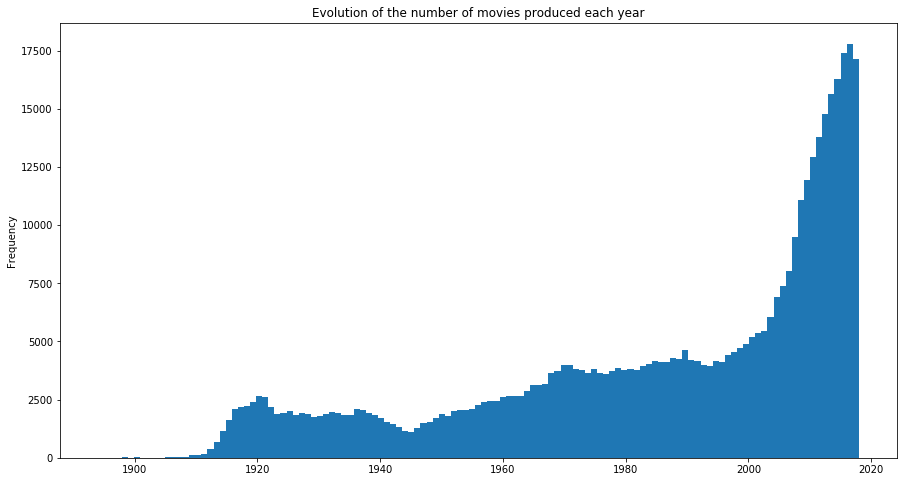

In [13]:
movies = basics.filter(basics.titleType == "movie")

movies_years = movies.select("startYear").dropna().toPandas()["startYear"]
print("Number of movies in the IMDb database: {}".format(movies.count()))

# We cast the years to int
movies_years = movies_years.astype(int)

# We plot the histogram only for already released movies (a.k.a. movies that were released in or before 2018)
movies_years = movies_years[movies_years <= 2018]
movies_years.plot(kind="hist", bins=movies_years.max() - movies_years.min() + 1, figsize=(15,8),
                  title="Evolution of the number of movies produced each year");
plt.savefig('docs/img/movies_evolution.png', transparent=True)
print("Number of movies made in 2018 : {}".format(movies_years[movies_years == 2018].shape[0]))
print("Number of movies made in 1998 : {}".format(movies_years[movies_years == 1998].shape[0]))

Number of TV series in the IMDb database: 156890
Number of TV episodes in the IMDb databse: 2917237
Number of TV series made in 2018 : 6495
Number of TV series made in 1998 : 2163


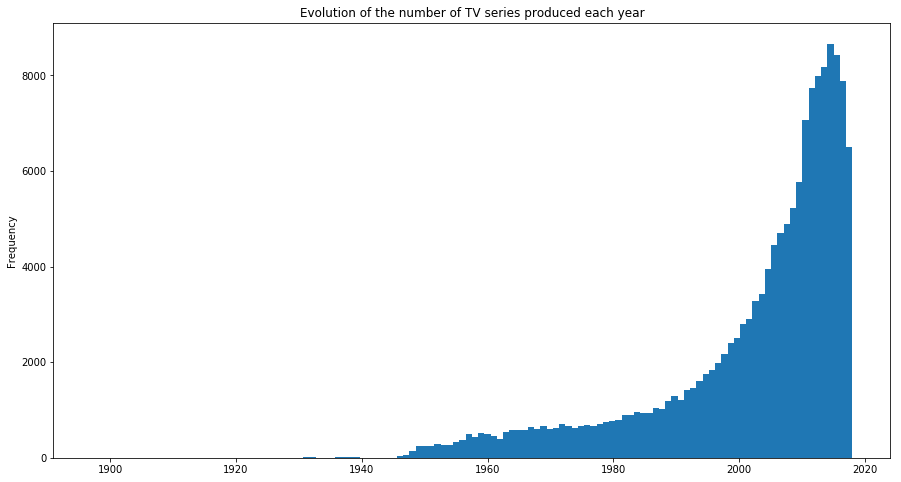

In [14]:
tvseries = basics.filter(((basics.titleType == "tvSeries") | (basics.titleType == "miniTvSeries")))
tvseries_years = tvseries.select("startYear").dropna().toPandas()["startYear"]
print("Number of TV series in the IMDb database: {}".format(tvseries.count()))
print("Number of TV episodes in the IMDb databse: {}".format(episode.count()))

# We cast the defined years to int
tvseries_years = tvseries_years.astype(int)

# We plot the histogram only for already released tv series (a.k.a. tv series that were released in or before 2018)
tvseries_years = tvseries_years[tvseries_years <= 2018]
tvseries_years.plot(kind="hist", bins=tvseries_years.max() - tvseries_years.min() + 1, figsize=(15,8),
                  title="Evolution of the number of TV series produced each year");
plt.savefig('docs/img/tv_series_evolution.png', transparent=True)
print("Number of TV series made in 2018 : {}".format(tvseries_years[tvseries_years == 2018].shape[0]))
print("Number of TV series made in 1998 : {}".format(tvseries_years[tvseries_years == 1998].shape[0]))

In [15]:
movies = movies.join(ratings, "tconst")

# Due to the way the structure of the OpenSubtitles dataset (require us to load one subtitle file per episode),
# we will only extract the topics on the first episode of each tv series (the pilot)
pilots = episode.filter(episode.seasonNumber == 1).filter(episode.episodeNumber == 1)
tvseries = tvseries.join(ratings, "tconst")
tvseries = tvseries.join(pilots, tvseries.tconst == pilots.parentTconst)

In [16]:
movies_col = ["tconst", "startYear", "genres", "averageRating", "numVotes"]
tvseries_col = ["tconst", "startYear", "genres", "averageRating", "numVotes", "episodeTconst"]
# According to IMDb database, ratings are only relevant when there are more than 5000 votes.
movies_relevant = movies.filter(movies.numVotes > 5000).select(*movies_col)
print("Number of relevant movies: {}".format(movies_relevant.count()))
tvseries_relevant = tvseries.filter(tvseries.numVotes > 5000).select(*tvseries_col)
print("Number of relevant TV series: {}".format(tvseries_relevant.count()))

Number of relevant movies: 11440
Number of relevant TV series: 1524


In [17]:
movies_relevant.write.parquet("movies.parquet", mode="overwrite")
tvseries_relevant.write.parquet("tvseries.parquet", mode="overwrite")

# Subtitle data

## Extracting the subtitles

**This part of the notebook is reserved for the subtitle data collection. Considering the data set is 31 GB long, the code below was ran on the cluster (and thus cannot be ran on this notebook).**

## Processing

Due to the problems we ran accross on the cluster (`nltk` not working properly, random failures) which made debugging really hard, we decided to do the entire processing locally.

We also noted that for most of the elements that we decided were relevant (in the first part of the notebook), the english subtitles were empty (the folders in the dataset existed, but they didn't contain any subtitle files), thus our results are less relevant.

In [28]:
#movies_subs = sqlContext.read.parquet('movies_subs.parquet')
tv_subs = sqlContext.read.parquet('tv_subs.parquet')

### Character names

In this section, we will try to find, for each element, the name of the characters that could be mentioned in the subtitles, so that we can remove them when we will work on the subtitles.

In [20]:
principals.show(12)

+---------+--------+---------+---------------+--------------------+--------------+
|   tconst|ordering|   nconst|       category|                 job|    characters|
+---------+--------+---------+---------------+--------------------+--------------+
|tt0000001|       1|nm1588970|           self|                null|   ["Herself"]|
|tt0000001|       2|nm0005690|       director|                null|          null|
|tt0000001|       3|nm0374658|cinematographer|director of photo...|          null|
|tt0000002|       1|nm0721526|       director|                null|          null|
|tt0000002|       2|nm1335271|       composer|                null|          null|
|tt0000003|       1|nm0721526|       director|                null|          null|
|tt0000003|       2|nm5442194|       producer|            producer|          null|
|tt0000003|       3|nm1335271|       composer|                null|          null|
|tt0000003|       4|nm5442200|         editor|                null|          null|
|tt0

In [21]:
# Select only the character names that correspond to real characters (i.e. category == actor),
# and remove all the undefined ones
characters = principals.filter(principals.category == 'actor').select('tconst', 'characters').dropna()
characters.show(5)

+---------+----------------+
|   tconst|      characters|
+---------+----------------+
|tt0000005|  ["Blacksmith"]|
|tt0000005|   ["Assistant"]|
|tt0000008|["Sneezing Man"]|
|tt0000009|["Mr. Hamilton"]|
|tt0000011|    ["Acrobats"]|
+---------+----------------+
only showing top 5 rows



In [23]:
# Removes the surrounding square brackets and quotes from the character names
def clean_name(name):
    return name[2: -2]
clean_names = udf(clean_name, StringType())
characters = characters.withColumn('characters', clean_names('characters'))

# Get the list of character names for each element
characters = characters.groupby('tconst').agg(collect_list('characters').alias("characters"))
characters.show(5)

+---------+----------+
|   tconst|characters|
+---------+----------+
|tt0001170|      [[]]|
|tt0001664|      [[]]|
|tt0001732|      [[]]|
|tt0002253|      [[]]|
|tt0002473|      [[]]|
+---------+----------+
only showing top 5 rows



In [30]:
# Append to each movie/TV series the name of its characters
#movies_subs = movies_subs.join(characters, "tconst")
tv_subs = tv_subs.join(characters, "tconst")

### Topic Extraction

We will first remove the unnecessary words (stop words, character names, words with length less than 4) and we lematize the remaining one (i.e. we transform the word to its correspinding root word). Once this is done, we decide to only keep the nouns, and we remove as topic the one with the highest number of occurence.

In [25]:
# Defines the parser to be in the english language
parser = English()

# Defines a function to tokenize the data into words and transforming them to lower case
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

# Lematize the given word
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

# Get the stop word list from nltk and add some more (that appeared a lot in our dataset)
en_stop = set(nltk.corpus.stopwords.words('english'))
more_stops = ['right', 'really', 'very', 'thing', 'sorry', 'would', 'could','please','hello','going','actually',
              'probably','something', *en_stop]

# Removes the useless tokens and lematize the others
def prepare_text_for_lda(text, characters):
    # Truncate the text of it is too lonbg to be processed by the parser
    if(len(text)>100000):
        text = text[:100000]
    characters = [w for c in characters for w in tokenize(c)]
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if (token not in more_stops) and (token not in characters)]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

# Return the top word (in terms of frequency)
def topWord(text, characters):
    tokens = prepare_text_for_lda(text,characters)
    tagged = nltk.pos_tag(tokens)
    filtered = filter(lambda x: x[1][:2] in ['NN'],tagged)
    results = [i for i,n in list(filtered)]
    c = Counter(results)
    output = sorted(c.items(),key=lambda x: x[1],reverse=True)
    output = [i for i, n in outputs]
    return [output[0]]

In [31]:
udf_topic = udf(topWord, ArrayType(StringType()))
tv_subs = tv_subs.withColumn('topic', udf_topic('subs','characters'))
#movies_subs = movies_subs.withColumn('topic', udf_topic('subs','characters'))

Traceback (most recent call last):
  File "/Users/vincent/.spark/python/pyspark/cloudpickle.py", line 235, in dump
    return Pickler.dump(self, obj)
  File "/Users/vincent/anaconda3/lib/python3.6/pickle.py", line 409, in dump
    self.save(obj)
  File "/Users/vincent/anaconda3/lib/python3.6/pickle.py", line 476, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/vincent/anaconda3/lib/python3.6/pickle.py", line 736, in save_tuple
    save(element)
  File "/Users/vincent/anaconda3/lib/python3.6/pickle.py", line 476, in save
    f(self, obj) # Call unbound method with explicit self
  File "/Users/vincent/.spark/python/pyspark/cloudpickle.py", line 372, in save_function
    self.save_function_tuple(obj)
  File "/Users/vincent/.spark/python/pyspark/cloudpickle.py", line 525, in save_function_tuple
    save(f_globals)
  File "/Users/vincent/anaconda3/lib/python3.6/pickle.py", line 476, in save
    f(self, obj) # Call unbound method with explicit self
  File "/U

PicklingError: Could not serialize object: TypeError: __init__() got an unexpected keyword argument 'encoding'

# Cities

We wanted to analyse which were the most common cited cities in the movies/TV series, to better analyse what kind of population it represents.

In [ ]:
geolocator = Nominatim()
def cities_to_coords(cities):
    res = []
    for i in cities:
        l = geolocator.geocode(i)
        if l is None:
            res.append((None, None))
        else:
            res.append((l.longitude, l.latitude))
        time.sleep(2)
    return res

In [ ]:
def plot_map(coords, data, legend, title):
    fig = plt.figure(figsize=(25, 10))
    m = Basemap(projection='cyl', resolution='l', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180)
    m.shadedrelief(scale=0.1)
    lon, lat = zip(*coords)
    m.scatter(lon, lat, latlon=True, c=data, s=50, cmap='Reds', alpha=0.9)
    plt.title(title)
    plt.colorbar(label=legend);

# Cost and box-office analysis

In order to show the importance of both the movie industry to introduce our data story, we wanted to highlight the evolution of production costs and yearly box-office, however, these data, which are present on IMDb, required us to register for a professional and paying account, thus we found a summary table on [The Numbers](https://www.the-numbers.com/movies/#tab=year), which even though it doesn't have as much details as the IMDb database, still shows pretty well the exponential evolution over the last century.

In [ ]:
box_office = pd.read_csv("data/box_office.csv", delimiter=";")
box_office.head(10)

In [ ]:
# Removes the TBD row, as well as the years that have not been reached yets (years bigger than 2018)
box_office.drop(range(0, 8), axis=0, inplace=True)

# Casts the year to integers
box_office["Year"] = box_office["Year"].astype(int)

# Fills all the missing number with value 0
box_office.fillna("0",inplace=True)

# Removes the year that have not been reached yet
box_office.head(5)

In [ ]:
box_office["Average Production Budget"] = box_office["Average Production Budget"].str.replace("[$,]", '').astype(
    float) / 10 ** 6
box_office["Combined Worldwide Box Office"] = box_office["Combined Worldwide Box Office"].str.replace(
    "[$,]",'').astype(int) / 10 ** 9
box_office["Total Movies"] = box_office["Total Movies"].str.replace(",",'').astype(int)
box_office["Yearly Budget"] = box_office["Average Production Budget"] * box_office["Total Movies"] / 10**3
box_office.head(5)

In [ ]:
years = box_office["Year"].values
average_budget = box_office["Average Production Budget"].values
movies = box_office["Total Movies"].values
bo = box_office["Combined Worldwide Box Office"].values
budget = box_office["Yearly Budget"].values

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(years, weights=bo, bins=(years.max() - years.min()+1))
plt.title("Evolution of the yearly world-wide box-office (in billion $)")
plt.savefig('docs/img/box_office.png', transparent=True)
print("Total box-office over the years: {} billion $".format(bo.sum()))

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(years, weights=budget, bins=(years.max() - years.min()+1))
plt.title("Evolution of the yearly production costs (in billion $)")
plt.savefig('docs/img/production_costs.png', transparent=True)
print("Total budget spent over the years: {} billion $".format(budget.sum()))
print("Production cost in 2018 : {}".format(budget[0]))
print("Production cost in 1998 : {}".format(budget[19]))